In [6]:
import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

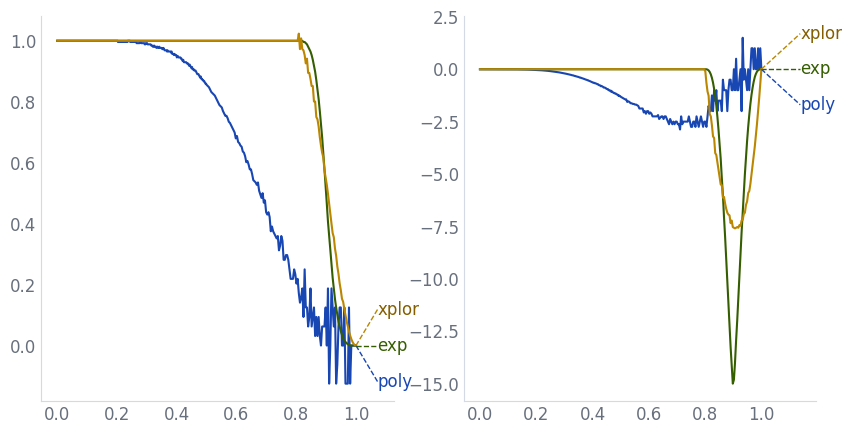

In [37]:
from cdv.layers import Context
from cdv.mace.edge_embedding import Envelope, PolynomialCutoff
from flax import linen as nn
from typing import Callable
import jax.numpy as jnp
from flax import linen as nn
from jaxtyping import Float, Array

from cdv.layers import Context, E3IrrepsArray


r_max = 1
p = 6
c = 0.1
cutoff_start = 0.8

xx = jnp.linspace(0, r_max, 1000, dtype=jnp.bfloat16)

class ExpCutoff(Envelope):
    """Original envelope. Designed to have as little effect as possible while keeping higher-order
    derivatives low.

    c should be between 0.1 and 1: higher values have smaller third, fourth derivatives but higher
    first, second derivatives.

    cutoff_start determines when the cutoff starts: values below this are not affected at all. This
    is as a fraction of r_max.
    """

    c: float = 0.1
    cutoff_start: float = 0.6

    @nn.compact
    def __call__(self, x: Float[Array, '*batch'], ctx: Context) -> Float[Array, '*batch']:
        r_on = self.cutoff_start * self.r_max
        t = jnp.clip((x - r_on) / (self.r_max - r_on), 0, 1)

        def exp_func(x):
            return (
                jnp.expm1(x * self.c) / jnp.expm1(self.c) * x * x * jnp.sin(jnp.pi * x / 2)
            )

        envelope = 1 - jnp.where(t < 0.5, exp_func(2 * t) / 2, 1 - exp_func(2 - 2 * t) / 2)

        return envelope


def xplor_cutoff(r, r_onset=r_max*cutoff_start, r_cutoff=r_max):
    """Apply smooth cutoff to pairwise interactions
    XPLOR smoothing function following HOOMD-blue and jax-md

    r: bond lengths
    r_onset: inner cutoff radius
    r_cutoff: cutoff radius

    inside cutoff radius, apply smooth cutoff envelope
    outside cutoff radius: hard zeros
    """
    r2 = r**2
    r2_on = r_onset**2
    r2_cut = r_cutoff**2

    # fmt: off
    smoothed = jnp.where(
        r < r_cutoff,
        (r2_cut - r2) ** 2 * (r2_cut + 2 * r2 - 3 * r2_on) / (r2_cut - r2_on) ** 3,
        0,
    )
    return jnp.where(r < r_onset, 1, smoothed)

def poly_cutoff(xx):
    return PolynomialCutoff(r_max=r_max, p=p).init_with_output(jr.key(123), xx, Context(training=False))[0]

def exp_cutoff(xx):
    return ExpCutoff(r_max=r_max, c=c, cutoff_start=cutoff_start).init_with_output(jr.key(123), xx, Context(training=False))[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for name, f in [
    ('poly', poly_cutoff),
    ('exp', exp_cutoff),
    ('xplor', xplor_cutoff),
]:
    yy = f(xx)
    ax1.plot(xx, yy, label=name)
    dyy = jax.vmap(jax.grad(f))(xx)
    ax2.plot(xx, dyy, label=name)
    
rp.line_labels(ax1)
rp.line_labels(ax2)